## On change la loss function --> (multinomial) CrossEntropy loss

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time


## Torch libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch.utils.data as data

# Generating the data base:
## First, we download the original images and fixation maps.
This requires having internet connexion

Size of the Folder 'ALLSTIMULI' : 225 Mo

Size of the Folder 'ALLFIXATIONMAPS' : 23,6 Mo

In [3]:
if not(os.path.exists('ALLSTIMULI')):
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen
    img='http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLSTIMULI.zip'
    resp = urlopen(img)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall()
    print('Download of ALLSTIMULI complete')
if not(os.path.exists('ALLFIXATIONMAPS')):
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen
    img='http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLFIXATIONMAPS.zip'
    resp = urlopen(img)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall()
    print('Download of ALLFIXATIONMAPS complete')

## Then, we generate the global images data base.
The images and fixations are 1003 grey images in numpy files of size 256x256, with memory space of 65 Ko each.

In total, we have:

GLOBAL_IMAGES :  59,7 Mo

GLOBAL_FIXATIONMAPS :    59,7 Mo

GLOBAL_IMAGES_TEST :        3,06 Mo

GLOBAL_FIXATIONMAPS_TEST : 3,06 Mo

In total we have 125.72 Mo

In [4]:
#size used for downsizing images
size=256

test_sample_ratio=5/100
#folder names
imdir_org,fixdir_org='ALLSTIMULI/ALLSTIMULI','ALLFIXATIONMAPS/ALLFIXATIONMAPS'
#imdir_new,fixdir_new='GLOBAL_IMAGES','GLOBAL_FIXATIONMAPS'
#imdir_test,fixdir_test='GLOBAL_IMAGES_TEST','GLOBAL_FIXATIONMAPS_TEST'
#creating empty folders:

imdir, fixdir = 'GLOBAL_IMAGES_ALL_PLAIN','GLOBAL_FIXATIONMAPS_ALL_PLAIN'
imdir_white, fixdir_white = 'GLOBAL_IMAGES_ALL_WHITE','GLOBAL_FIXATIONMAPS_ALL_WHITE'



In [5]:
for directory in [imdir,fixdir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
#image and fixation names
import fnmatch #fnmatch to keep only image files
image_files =fnmatch.filter(os.listdir(imdir_org), '*.jpeg')
fixation_files = []
for image_name in image_files:
    fixation_files.append(image_name[:-5] +'_fixMap.jpg')
#number of images : 1003
N=len(image_files)
#N_test=int(l*test_sample_ratio)
#N_train=l-N_test
print('Total number of images :', N)
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
#default parameters for the whitening
im = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

Total number of images : 1003


In [6]:
#print(os.listdir(imdir_org))

In [7]:
if False : #not os.path.exists(imdir):
    for idx in range(N):
        if idx%100==0:
            print('Avancement=',int(idx/N*100),'%')
        #check if file exists
        '''if idx<=N_train:
            img_dir,fix_dir=imdir_new,fixdir_new
        else:
            img_dir,fix_dir=imdir_test,fixdir_test'''
        #if not (os.path.exists(os.path.join(img_dir,image_files[idx][:-5])) and os.path.exists(os.path.join(fix_dir,fixation_files[idx][:-4])) ):
        #loading images and fixations
        img_name = os.path.join(imdir_org,image_files[idx])
        fix_name = os.path.join(fixdir_org,fixation_files[idx])
        image = PIL.Image.open(img_name)
        fixation=PIL.Image.open(fix_name)
        #resizing
        image=image.resize((size,size))
        fixation=fixation.resize((size,size))
        #saving in a temporary file:
        image.save('temp_image.jpeg')
        #whitening
        image=im.imread('temp_image.jpeg')
            ##whitening only works for pair shape
        raws=image.shape[0]
        columns=image.shape[1]
        if raws%2!=0:
            image=image[:-1,:]
            fixation=fixation[:-1,:]
        if columns%2!=0:
            image=image[:,:-1]
            fixation=fixation[:,:-1]
        raws=image.shape[0]
        columns=image.shape[1]
        im.set_size((raws,columns))
            ##apply whitening
        image = im.whitening(image)
        image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')
        #saving
        '''if idx<=N_train:
            img_dir,fix_dir=imdir_new,fixdir_new
        else:
            img_dir,fix_dir=imdir_test,fixdir_test'''
        np.save(os.path.join(imdir,image_files[idx][:-5]), np.array(image,dtype=np.uint8))
        np.save(os.path.join(fixdir,fixation_files[idx][:-4]), np.array(fixation,dtype=np.uint8))
    print('Avancement= 100 %')
    print('COMPLETE : GLOBAL IMAGES AND FIXATION MAPS GENERATED SUCCESSFULLY.')

### Tests

In [8]:
i = 0

'''image_ref_dir = imdir_org
image_ref_names=os.listdir(image_ref_dir)
image_ref=np.load(os.path.join(image_ref_dir,image_ref_names[i]))

fix_ref_dir = fixdir_org
fix_ref_names=os.listdir(fix_ref_dir)
fix_ref=np.load(os.path.join(fix_ref_dir,fix_ref_names[i]))'''

image_dir = imdir #imdir_new
image_names=os.listdir(image_dir)
image=np.load(os.path.join(image_dir,image_names[i]))

image_dir_white = imdir_white #imdir_new
image_white_names=os.listdir(image_dir_white)
image_white=np.load(os.path.join(image_dir_white,image_names[i]))

fix_dir = fixdir #fixdir_new
fix_names=os.listdir(fix_dir)
fix=np.load(os.path.join(fix_dir,fix_names[i]))


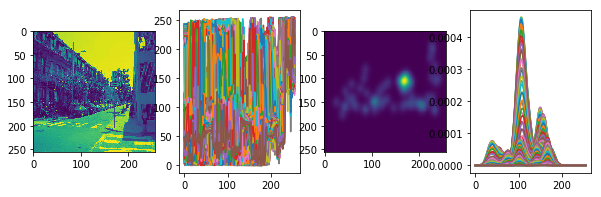

In [9]:
plt.figure(figsize = (10,3))
'''plt.subplot(141)
plt.imshow(image_ref)
plt.subplot(142)
_ = plt.plot(fix_ref)'''
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
_ = plt.plot(image)
plt.subplot(143)
plt.imshow(fix)
plt.subplot(144)
_ = plt.plot(fix/sum(fix.flatten()))

(array([95]), array([170]))
170


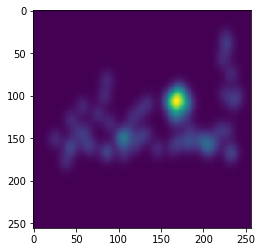

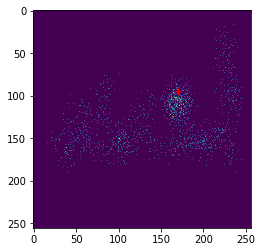

In [10]:
plt.imshow(fix)
m = fix/sum(fix.flatten())
m = m.flatten()

'''for i in range(20):
    print(np.where(np.random.multinomial(1, m) == 1)[0][0])'''

m_mult = np.random.multinomial(2000, m)
plt.figure()
plt.imshow(m_mult.reshape(256, 256))

m_mult = np.random.multinomial(1, m).reshape(256, 256)
print(np.where(m_mult == 1))
coord = np.where(m_mult == 1)
plt.plot(coord[1], coord[0], 'r+')
print(coord[1][0])
    

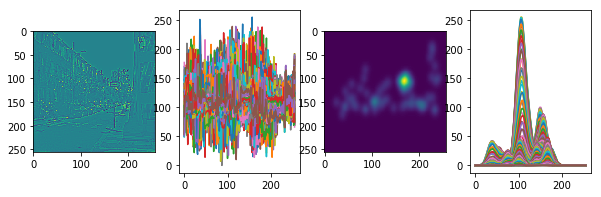

In [11]:
plt.figure(figsize = (10,3))
'''plt.subplot(141)
plt.imshow(image_ref)
plt.subplot(142)
_ = plt.plot(fix_ref)'''
plt.subplot(141)
plt.imshow(image_white)
plt.subplot(142)
_ = plt.plot(image_white)
plt.subplot(143)
plt.imshow(fix)
plt.subplot(144)
_ = plt.plot(fix)

## Vision stuff

In [12]:
from LogGabor import LogGabor

In [13]:
N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 24, 15, 2, 256, 256, 1.21 #1.41 #1.25 #
#N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 12, 8, 2, 256, 256, 1.41
verbose = 1
OFFSET_STD = 15
OFFSET_MAX = 30

## Pierre's stuff

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [14]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=1, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina

#### Full encoding

In [15]:
#del retina

In [16]:
FIC_NAME = 'retina_256_24_ecc_15.npy'
if not os.path.exists(FIC_NAME):
    retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho) #, ecc_max=1)
    np.save(FIC_NAME, retina)
else:
    retina = np.load(FIC_NAME)
print(retina.shape)


(6, 24, 15, 2, 65536)


In [17]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(4320, 65536)


In [18]:
FIC_NAME = 'retina_inverse_256_24_ecc_15.npy'
if not os.path.exists(FIC_NAME):
    retina_inverse = np.linalg.pinv(retina_vector)
    np.save(FIC_NAME, retina_inverse)
else:
    retina_inverse = np.load(FIC_NAME)
print(retina_inverse.shape)

(65536, 4320)


#### Orientation invariant power encoding (colliculus??)

In [19]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(24, 15, 65536)


In [20]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(360, 65536)


In [21]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(65536, 360)


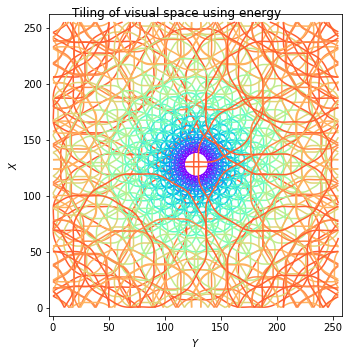

In [22]:
energy = colliculus ** 2
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

## Images dataset

In [23]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

In [24]:
np.random.rand() > 0.5

True

In [25]:
#im = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

class Transform(object):
    """Rescale the image through LogGabors

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self):
        #assert isinstance(output_size, (int, tuple))
        #self.output_size = output_size
        pass

    def __call__(self, sample):
        image, image_white, fixmap = sample['image'], sample['image_white'], sample['fixation']
        
        #i_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        #j_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        
        if np.random.rand() > 0.5:
            image_white = np.fliplr(image_white)
            image = np.fliplr(image)
            fixmap = np.fliplr(fixmap)
        
        m = fixmap/sum(fixmap.flatten())
        m = m.flatten()
        m_mult = np.random.multinomial(1, m).reshape(256, 256)
        coord = np.where(m_mult == 1)
        i_offset = 127 - coord[0][0]
        j_offset = 127 - coord[1][0]
        
        '''i_offset = 0
        j_offset = -50'''
        
        image_white = np.roll(image_white, i_offset, axis=0)
        image_white = np.roll(image_white, j_offset, axis=1)       
        image_retina = retina_vector @ np.ravel(image_white)
        image_retina /= np.std(image_retina)
        
        image = np.roll(image, i_offset, axis=0)
        image = np.roll(image, j_offset, axis=1)     
        image_colliculus = colliculus_vector @ np.ravel(image)
        #image_colliculus -= np.mean(image_colliculus)
        image_colliculus /= np.std(image_colliculus)
        
        fixmap = np.roll(fixmap, i_offset, axis=0)
        fixmap = np.roll(fixmap, j_offset, axis=1)     
        fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)
        fixmap_colliculus = fixmap_colliculus/sum(fixmap_colliculus)
        
        return {'image': image_colliculus, 'image_white': image_retina, 'fixation': fixmap_colliculus}
        #r 

In [26]:
## test

In [27]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, image_white, fixmap = sample['image'], sample['image_white'], sample['fixation']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'image_white': torch.from_numpy(image_white),
                'fixation': torch.from_numpy(landmarks)}

In [28]:
class ImageDataset(data.Dataset):
    """image dataset."""

    def __init__(self, imdir, imdir_white, fixdir, transform=None, index = None):
        """
        Args:
            imdir (string): Path to the image folder
            fixdir (string): Path to the fixation maps folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imdir = imdir
        self.fixdir = fixdir
        self.imdir_white = imdir_white
        if index is None :
            print('OK')
            self.image_names=os.listdir(imdir)
            self.fix_names=os.listdir(fixdir)
        else:
            self.image_names=np.array(os.listdir(imdir))[index]
            self.fix_names=np.array(os.listdir(fixdir))[index]
        self.transform = transform # we do not use transforms
        #self.data_loader=data.DataLoader(self,batch_size=batch_size) : did not work
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image=np.load(os.path.join(self.imdir,self.image_names[idx]))
        image_white=np.load(os.path.join(self.imdir_white,self.image_names[idx]))
        fix_map=np.load(os.path.join(self.fixdir,self.fix_names[idx]))/255 # to transform between 0 and 1 (for the BCELoss to work)

        sample = {'image': image, 'image_white': image_white, 'fixation': fix_map}

        if self.transform:
            sample = self.transform(sample)
        
        return sample


### Tests

In [29]:
trans = Transform()
dataset = ImageDataset(image_dir,image_dir_white,fix_dir)

OK


In [30]:
i = 0
sample = dataset[i] #['image'], dataset[i]['fixation'] 

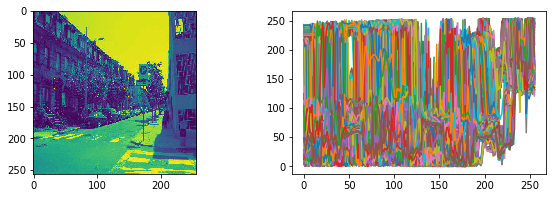

In [31]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image'])
plt.subplot(122)
_ = plt.plot(sample['image'])

9 -3
15


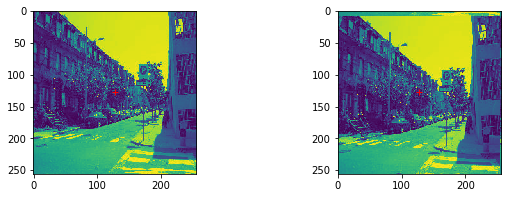

In [32]:
image_off = sample['image']
i_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
j_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
print(i_offset, j_offset)
print(OFFSET_STD)
image_off = np.roll(image_off, i_offset, axis=0)
image_off = np.roll(image_off, j_offset, axis=1)     
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image'])
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')
plt.subplot(122)
plt.imshow(image_off)
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

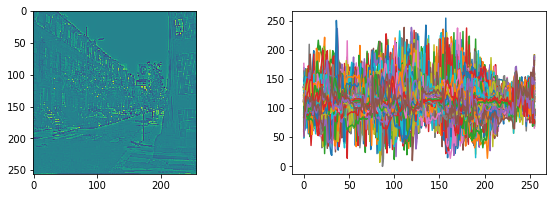

In [33]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image_white'])
plt.subplot(122)
_ = plt.plot(sample['image_white'])

In [34]:
'''train = True
batch_size = 10
data_loader = torch.utils.data.DataLoader(dataset, train=train, download=True, batch_size=batch_size, shuffle=True)'''
dataloader = data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

In [35]:
batch = next(iter(dataloader))

In [36]:
batch['image'].shape

torch.Size([10, 256, 256])

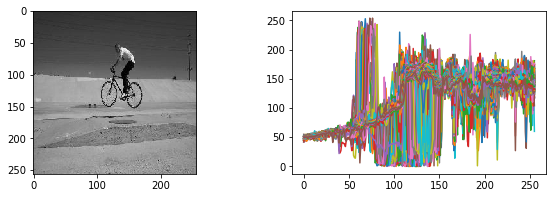

In [37]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(batch['image'][0,:,:], cmap = 'gray')
plt.subplot(122)
_ = plt.plot(batch['image'][0,:,:])

### Encoding test

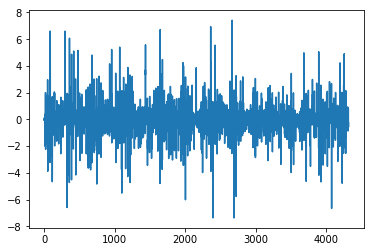

In [38]:
trans = Transform()
sample_retina = trans(sample) #retina_vector @ np.ravel(sample['image'])
plt.plot(sample_retina['image_white'])

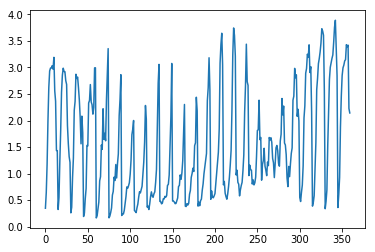

In [39]:
trans = Transform()
sample_retina = trans(sample) #retina_vector @ np.ravel(sample['image'])
plt.plot(sample_retina['image'])

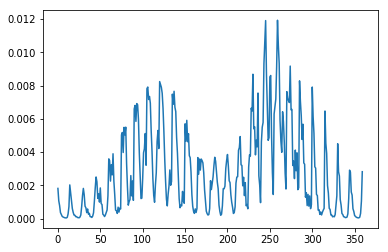

In [40]:
#data_colliculus = colliculus_vector @ np.ravel(sample['fixation'])
plt.plot(sample_retina['fixation'])

In [41]:
### Polar plot

In [42]:
N_eccentricity * N_azimuth

360

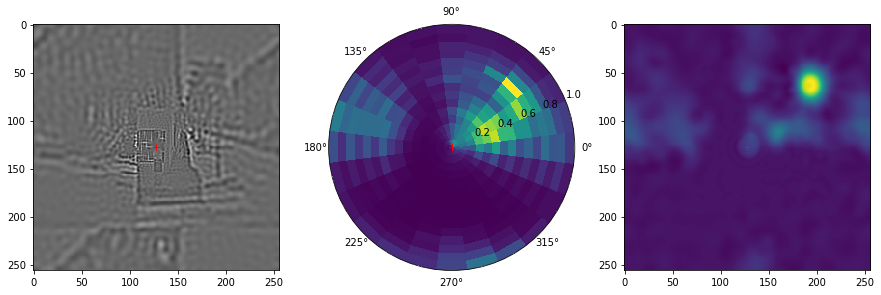

In [43]:
sample_retina = trans(sample)
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
f = plt.figure(figsize = (15,5))

plt.subplot(131)
data_retina = sample_retina['image_white']
image_white = retina_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image_white.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

ax = f.add_subplot(132, projection='polar')
vec = sample_retina['fixation']
ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
plt.plot(0,0, 'r+')

ax = f.add_subplot(133)
plt.imshow((colliculus_inverse @ vec).reshape(N_X, N_Y) )#sample['fixation'])
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

In [44]:
colliculus_inverse @ vec

array([ -1.48845182e-04,  -1.64648379e-04,  -1.69411774e-04, ...,
         1.13045370e-05,  -4.28306502e-05,  -8.86504490e-05])

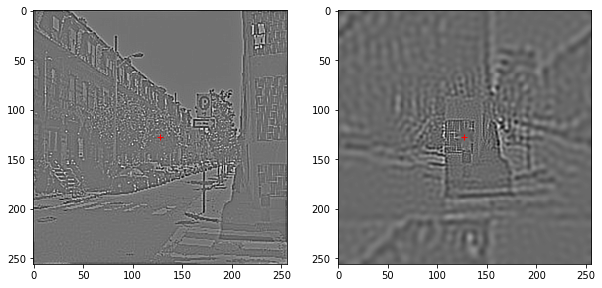

In [45]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image_white'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
data_retina = sample_retina['image_white']
image_white = retina_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image_white.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

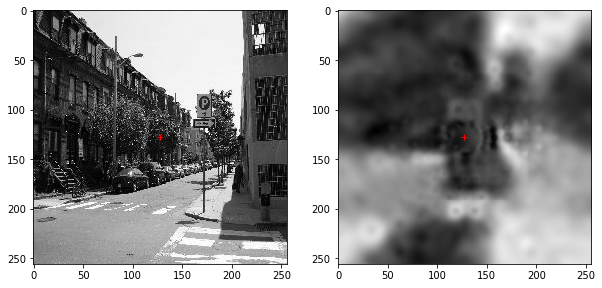

In [48]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
data_retina = sample_retina['image']
image = colliculus_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

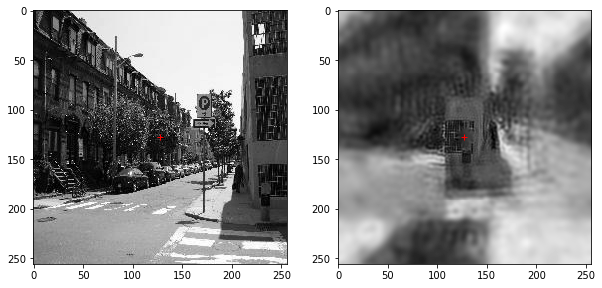

In [49]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
plt.imshow(10 * image_white.reshape(N_X, N_Y)+image.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')


In [50]:
if False:
    transform = Transform()
    batch_size = 100
    dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    batch = next(iter(dataloader))

In [51]:
if False :
    fixmap_avg = sum(batch['fixation'])/batch_size

    f = plt.figure(figsize = (15, 5))

    i = 3

    plt.subplot(131)
    #for i in range(10):
    plt.plot(batch['fixation'][i,:], 'g')
    plt.plot(batch['fixation'][i,:] - fixmap_avg)
    plt.plot(fixmap_avg,'r')

    ax = f.add_subplot(132, projection='polar')
    vec = batch['fixation'][i,:] 
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0, 'r+')

    ax = f.add_subplot(133, projection='polar')
    vec = batch['fixation'][i,:] - fixmap_avg
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0, 'r+')



#### Input vectors encoding

In [52]:
'''def image_fullfield(image):
    image_retina = retina_vector @ np.ravel(image)
    return image_retina'''

'def image_fullfield(image):\n    image_retina = retina_vector @ np.ravel(image)\n    return image_retina'

#### Output vectors (Accuracy/Saliency map) encoding

In [53]:
'''def fixmap_fullfield(fixmap):   
    fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)
    return fixmap_colliculus'''

'def fixmap_fullfield(fixmap):   \n    fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)\n    return fixmap_colliculus'

In [54]:
'''def couples(image, fixmap): #, device):
    #data = data.to(device)
    v = image_fullfield(data)
    a = fixmap_fullfield(fixmap)
    return (v, a)'''

'def couples(image, fixmap): #, device):\n    #data = data.to(device)\n    v = image_fullfield(data)\n    a = fixmap_fullfield(fixmap)\n    return (v, a)'

#### Hyperparameters

In [55]:
minibatch_size = 25  # quantity of examples that'll be processed
lr = 1e-4 #0.05

n_hidden1_white = 2000 #800 #
n_hidden1 = 500 #200 #
n_hidden2 = 500 #50 #
n_hidden3 = 50  #10 #50
n_hidden4 = 500 #50

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
train = True

n_hidden1 500  / n_hidden2 500


In [56]:
torch.cuda.is_available()

False

In [57]:
do_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [61]:
transform = Transform()
transform_test = Transform()

image_dir = imdir #'GLOBAL_IMAGES_ALL'
fix_dir = fixdir #'GLOBAL_FIXATIONMAPS_ALL'

'''image_names=os.listdir(image_dir)
print (len(image_names))
fix_names=os.listdir(fix_dir)
print (len(fix_names))
for i in range(len(image_names)):
    if image_names[i][:7] != fix_names[i][:7]:
        print(image_names[i], fix_names[i])'''

n = len(os.listdir(image_dir))
index = np.arange(n)
np.random.shuffle(index)
print(index)
index_train = index[:900]
index_test = index[900:]

train_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform, index = index_train)
train_loader = data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True, num_workers=4)

test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

[333 298 123 ..., 770 962 189]


In [62]:
len(train_dataset)

900

In [63]:
'''for batch_idx, batch in enumerate(train_loader):
    print (batch_idx)'''

'for batch_idx, batch in enumerate(train_loader):\n    print (batch_idx)'

#### Network

In [64]:
BIAS = True

class Net(torch.nn.Module):
    
    def __init__(self, n_feature, n_hidden1, n_hidden1_white, n_hidden2, n_hidden3, n_hidden4, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature // N_theta // N_phase, n_hidden1, bias = BIAS)
        self.hidden1_white = torch.nn.Linear(n_feature, n_hidden1_white, bias = BIAS)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2, bias = BIAS)
        self.hidden2_white = torch.nn.Linear(n_hidden1_white, n_hidden2, bias = BIAS)
        self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3, bias = BIAS)
        self.hidden4 = torch.nn.Linear(n_hidden3, n_hidden4, bias = BIAS)
        self.predict = torch.nn.Linear(n_hidden4, n_output, bias = BIAS)
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, image, image_white):
        data_white = F.relu(self.hidden1_white(image_white))
        data = F.relu(self.hidden1(image))
        data = F.relu(self.hidden2(data) + self.hidden2_white(data_white))
        data = F.dropout(data, p = .5) #self.dropout)
        #data = F.relu(self.hidden3(data))
        data = self.hidden3(data)
        data = F.relu(self.hidden4(data))
        data =  self.predict(data)
        return data


In [65]:
net = Net(n_feature=N_theta*N_azimuth*N_eccentricity*N_phase,\
          n_hidden1=n_hidden1,\
          n_hidden1_white=n_hidden1_white,\
          n_hidden2=n_hidden2,\
          n_hidden3=n_hidden3,\
          n_hidden4=n_hidden4,\
          n_output=N_azimuth*N_eccentricity)

In [66]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [70]:
#loss_func = torch.nn.BCEWithLogitsLoss()
def loss_func(pred, soft_targets):
    # cross entropy
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [71]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          verbose=1):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
       
        log_image_batch = batch['image'].float()
        log_image_batch_white = batch['image_white'].float()
        log_fixmap_batch = batch['fixation'].float()
        
        prediction = net(log_image_batch, log_image_batch_white)
        loss = loss_func(prediction, log_fixmap_batch) 

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx * minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [72]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity):
    #for batch_idx, (data, label) in enumerate(test_loader):
    batch = next(iter(test_loader))
    batch_size = len(batch)
    
    '''log_image_batch = np.zeros((batch_size, 1, vsize))
    log_fixmap_batch = np.zeros((batch_size, 1, asize))
    
    for idx in range(batch_size):
        log_image_batch[idx, 0, :], log_fixmap_batch[idx, 0, :] = couples(batch['image'][idx, :, :], batch['fixation'][idx, :, :])
        #input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset)
        #target[idx, :] = a_data[idx, 0, :]'''


    prediction = net(batch['image'].float(), batch['image_white'].float())
    loss = loss_func(prediction, batch['fixation'].float())

    return loss.data.numpy()


In [80]:
'''REDRAW = True
CONTINUE = False
EPOCHS = 1
FIC_NAME = '2018-11-21-Malek recap.npy'

def entraine():
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)  

if not os.path.exists(FIC_NAME) or REDRAW:
    print('OK')
    entraine()    
else:
    net = torch.load(FIC_NAME)   
    if CONTINUE:
        entraine()'''
        
FIC_NAME = '2018-11-21-Malek recap.npy'
EPOCHS = 150 #50

if True : #not os.path.exists(FIC_NAME):
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)    
else:
    net = torch.load(FIC_NAME)    

0
Starting training...
[0/900] Loss: 5.672605514526367 Time: 0.37 mn
[250/900] Loss: 5.686397075653076 Time: 1.17 mn
[500/900] Loss: 5.5782999992370605 Time: 2.18 mn
[750/900] Loss: 5.654794216156006 Time: 3.05 mn
Test set: Final Accuracy: 5.682
1
Starting training...
[0/900] Loss: 5.573282718658447 Time: 0.39 mn
[250/900] Loss: 5.591439247131348 Time: 1.22 mn
[500/900] Loss: 5.639117240905762 Time: 2.23 mn
[750/900] Loss: 5.708780765533447 Time: 3.00 mn
Test set: Final Accuracy: 5.644
2
Starting training...
[0/900] Loss: 5.6579155921936035 Time: 0.36 mn
[250/900] Loss: 5.631577491760254 Time: 1.08 mn
[500/900] Loss: 5.712874412536621 Time: 2.06 mn
[750/900] Loss: 5.7324604988098145 Time: 2.77 mn
Test set: Final Accuracy: 5.651
3
Starting training...
[0/900] Loss: 5.722796440124512 Time: 0.36 mn
[250/900] Loss: 5.670473098754883 Time: 1.05 mn
[500/900] Loss: 5.726990222930908 Time: 2.00 mn
[750/900] Loss: 5.680688858032227 Time: 2.70 mn
Test set: Final Accuracy: 5.718
4
Starting traini

[500/900] Loss: 5.667204856872559 Time: 2.20 mn
[750/900] Loss: 5.6819562911987305 Time: 3.02 mn
Test set: Final Accuracy: 5.690
34
Starting training...
[0/900] Loss: 5.67264986038208 Time: 0.45 mn
[250/900] Loss: 5.689130783081055 Time: 1.29 mn
[500/900] Loss: 5.641488075256348 Time: 2.24 mn
[750/900] Loss: 5.643345355987549 Time: 3.07 mn
Test set: Final Accuracy: 5.664
35
Starting training...
[0/900] Loss: 5.721125602722168 Time: 53.86 mn
[250/900] Loss: 5.6808390617370605 Time: 54.59 mn
[500/900] Loss: 5.752124309539795 Time: 55.46 mn
[750/900] Loss: 5.6170334815979 Time: 56.21 mn
Test set: Final Accuracy: 5.715
36
Starting training...
[0/900] Loss: 5.654628753662109 Time: 0.39 mn
[250/900] Loss: 5.5973429679870605 Time: 1.13 mn
[500/900] Loss: 5.677565097808838 Time: 1.98 mn
[750/900] Loss: 5.700898170471191 Time: 2.85 mn
Test set: Final Accuracy: 5.659
37
Starting training...
[0/900] Loss: 5.672018527984619 Time: 0.41 mn
[250/900] Loss: 5.609997749328613 Time: 1.20 mn
[500/900] Lo

Test set: Final Accuracy: 5.689
67
Starting training...
[0/900] Loss: 5.658854961395264 Time: 0.40 mn
[250/900] Loss: 5.727032661437988 Time: 1.19 mn
[500/900] Loss: 5.596113681793213 Time: 2.07 mn
[750/900] Loss: 5.615466594696045 Time: 2.82 mn
Test set: Final Accuracy: 5.677
68
Starting training...
[0/900] Loss: 5.62027645111084 Time: 0.40 mn
[250/900] Loss: 5.672637462615967 Time: 1.16 mn
[500/900] Loss: 5.726433753967285 Time: 2.00 mn
[750/900] Loss: 5.67766809463501 Time: 2.78 mn
Test set: Final Accuracy: 5.709
69
Starting training...
[0/900] Loss: 5.663787364959717 Time: 0.41 mn
[250/900] Loss: 5.604204177856445 Time: 1.16 mn
[500/900] Loss: 5.64763069152832 Time: 2.02 mn
[750/900] Loss: 5.62449836730957 Time: 2.81 mn
Test set: Final Accuracy: 5.678
70
Starting training...
[0/900] Loss: 5.714779853820801 Time: 0.37 mn
[250/900] Loss: 5.766183853149414 Time: 1.14 mn
[500/900] Loss: 5.683561325073242 Time: 1.97 mn
[750/900] Loss: 5.598212718963623 Time: 2.76 mn
Test set: Final Accu

[250/900] Loss: 5.608246803283691 Time: 1.39 mn
[500/900] Loss: 5.612118721008301 Time: 2.29 mn
[750/900] Loss: 5.678995609283447 Time: 3.24 mn
Test set: Final Accuracy: 5.671
101
Starting training...
[0/900] Loss: 5.7338666915893555 Time: 0.46 mn
[250/900] Loss: 5.6187424659729 Time: 1.39 mn
[500/900] Loss: 5.749542236328125 Time: 2.54 mn
[750/900] Loss: 5.660439491271973 Time: 3.45 mn
Test set: Final Accuracy: 5.665
102
Starting training...
[0/900] Loss: 5.675607681274414 Time: 0.54 mn
[250/900] Loss: 5.677100658416748 Time: 1.43 mn
[500/900] Loss: 5.635603904724121 Time: 2.53 mn
[750/900] Loss: 5.753631591796875 Time: 3.44 mn
Test set: Final Accuracy: 5.673
103
Starting training...
[0/900] Loss: 5.6689324378967285 Time: 0.48 mn
[250/900] Loss: 5.707022666931152 Time: 1.52 mn
[500/900] Loss: 5.695390224456787 Time: 2.67 mn
[750/900] Loss: 5.679117202758789 Time: 3.67 mn
Test set: Final Accuracy: 5.697
104
Starting training...
[0/900] Loss: 5.690670490264893 Time: 0.51 mn
[250/900] Lo

Process Process-977:
Process Process-978:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-28-c97f2210d95f>", line 31, in __getitem__
    fix_map=np.load(os.path.join(self.fixdir,self.fix_names[idx]))/255 # to transform between 0 and 1 (for the BCELoss to work)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/numpy/lib/npyio.py", line 419, in load
    pickle_kwargs=pickle_kwargs)
  File "/usr/local/lib/python3

KeyboardInterrupt: 

KeyboardInterrupt


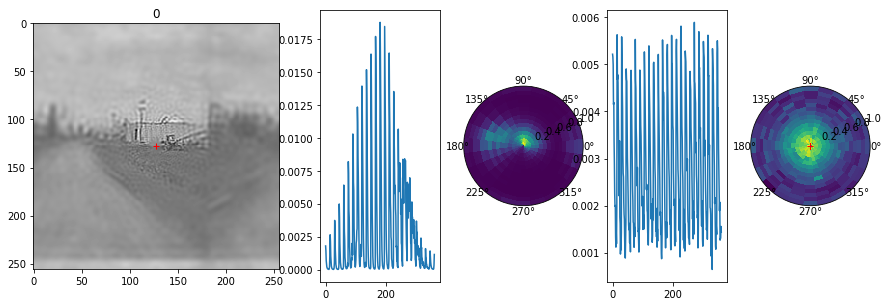

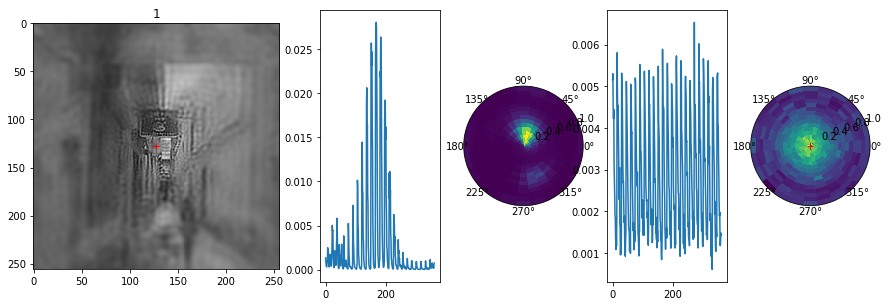

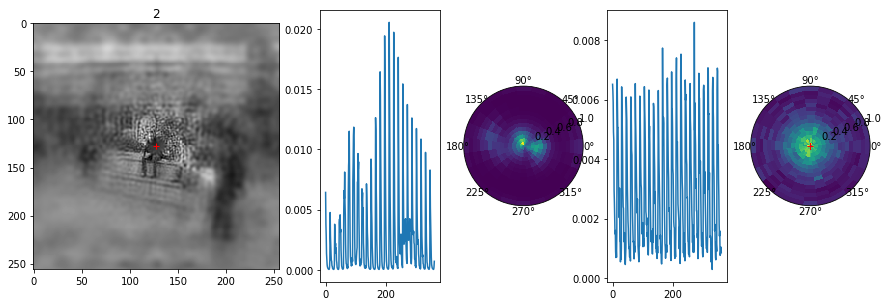

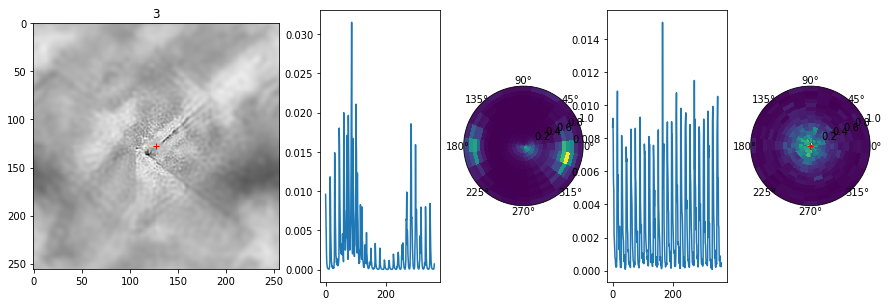

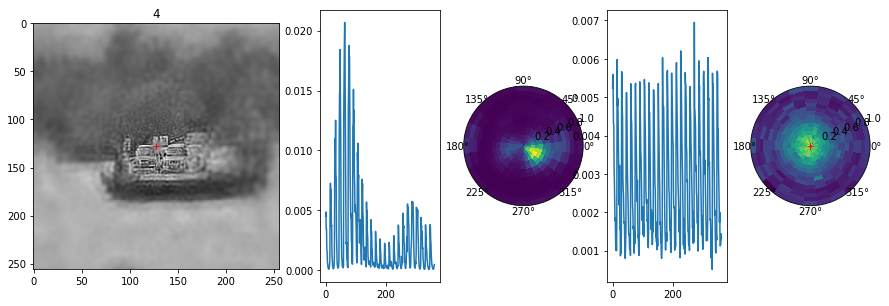

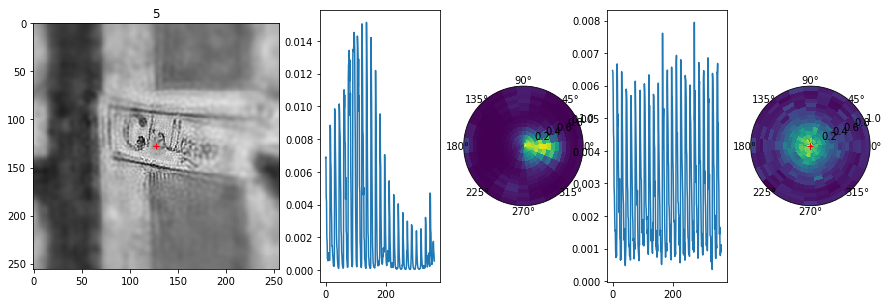

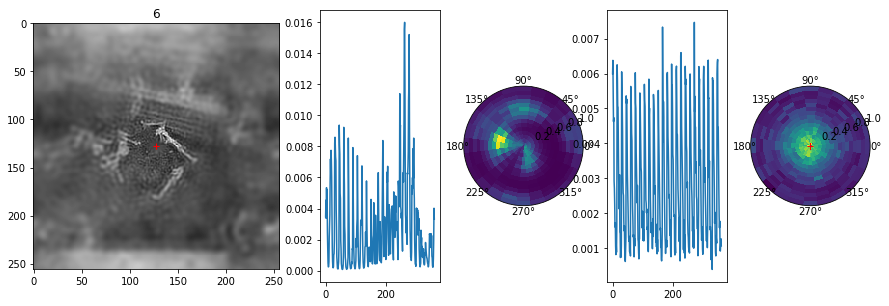

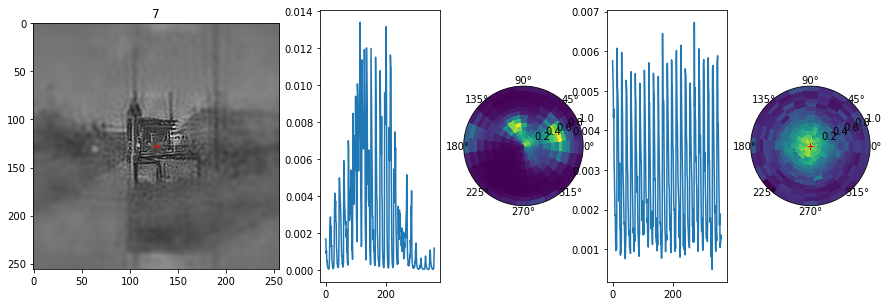

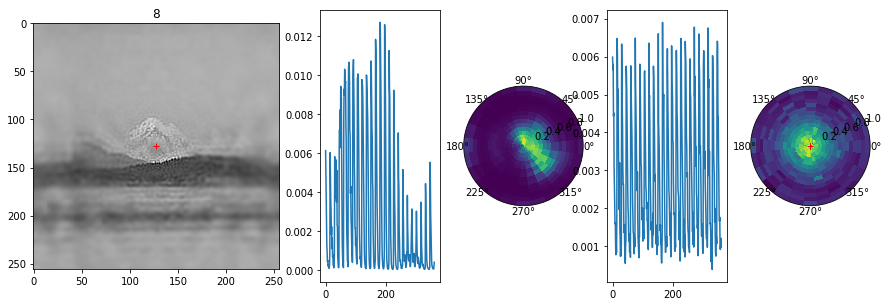

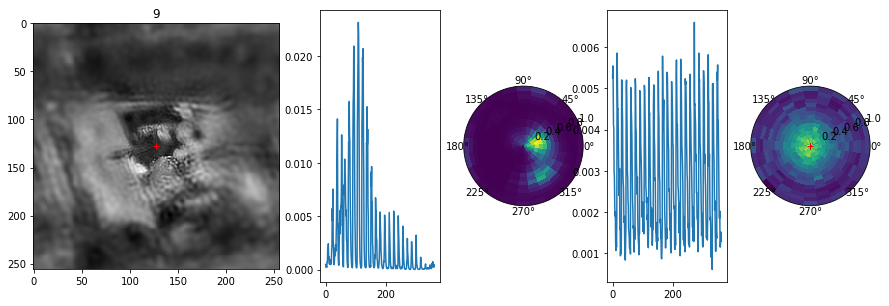

In [81]:
transform_test = Transform() 
test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

batch = next(iter(test_loader))
#batch = next(iter(train_loader))
for _ in range(10):
    image = colliculus_inverse @ batch['image'][_,:]
    image_white = retina_inverse @ batch['image_white'][_,:]
    plt.figure(figsize = (15, 5))
    
    #plt.subplot(161)
    #plt.plot(batch['image_white'][_,:])
    plt.subplot(131)
    plt.imshow(image_white.reshape(N_X, N_X) * 20 + image.reshape(N_X, N_X) , cmap = 'gray')
    plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')
    plt.title(_)
    plt.subplot(163)
    plt.plot(batch['fixation'][_,:])    
    #col = colliculus_inverse @ batch['fixation'][_,:]
    ax = plt.subplot(164, projection='polar')
    vec = batch['fixation'][_,:]
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_ = batch['image'][_,:].float()
    in_white = batch['image_white'][_,:].float()
    out = net(in_, in_white)
    plt.subplot(165)
    out_sig = F.softmax(out).detach().numpy()
    plt.plot(out_sig) #.detach().numpy()) #_sig)    
    #view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0,'r+')
    #plt.imshow(view.reshape(128, 128))
                                 

In [ ]:
print('\a')